In [ ]:
# ========================================
# 📦 ENV + DEPENDENCIES
# ========================================
import sys
# Initial clear of sys.modules to ensure any old problematic modules are gone before reinstall
for m in ['efficientnet', 'efficientnet.keras', 'segmentation_models', 'segmentation_models.keras']:
    if m in sys.modules:
        del sys.modules[m]

!nvidia-smi
!pip uninstall -y segmentation-models efficientnet # Uninstall existing versions
!pip install -q gdown segmentation-models keras-cv-attention-models einops

import os, zipfile, gdown
from google.colab import drive
drive.mount('/content/drive')


FILE_ID = "1wr3Xui092DX_nffV3y9GOID_KPXWY77N"
DOWNLOAD = True
ZIP_OUTPUT = "/content/dataset.zip"
DATASET_DIR = "/content/data"

if DOWNLOAD:
    url = f"https://drive.google.com/uc?id={FILE_ID}"
    gdown.download(url, ZIP_OUTPUT, quiet=False)
    with zipfile.ZipFile(ZIP_OUTPUT, "r") as zip_ref:
        zip_ref.extractall(DATASET_DIR)
else:

    pass

print("Dataset directory:", DATASET_DIR)

# --- Patch for efficientnet/__init__.py compatibility with newer TensorFlow ---
# This addresses 'AttributeError: module 'keras.utils' has no attribute 'generic_utils''

target_file_path = None
for p in sys.path:
    possible_path = os.path.join(p, 'efficientnet', '__init__.py')
    if os.path.exists(possible_path):
        target_file_path = possible_path
        break

if target_file_path:
    with open(target_file_path, 'r') as f:
        lines = f.readlines()

    modified_lines = []
    patched = False
    for line in lines:
        if 'keras.utils.generic_utils.get_custom_objects().update(custom_objects)' in line:
            modified_lines.append(f'# {line.strip()} # Patched by Colab Agent for TF2.x compatibility\n')
            patched = True
        else:
            modified_lines.append(line)

    if patched:
        with open(target_file_path, 'w') as f:
            f.writelines(modified_lines)
        print(f"Patched: {target_file_path}")
    else:
        print("No patch needed or already patched for efficientnet/__init__.py")
else:
    print("efficientnet/__init__.py not found for patching.")

# --- End of Patch ---

Thu Nov 20 16:20:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Downloading...
From (original): https://drive.google.com/uc?id=1wr3Xui092DX_nffV3y9GOID_KPXWY77N
From (redirected): https://drive.google.com/uc?id=1wr3Xui092DX_nffV3y9GOID_KPXWY77N&confirm=t&uuid=24b907fc-6796-4136-98bd-0f542d91cacb
To: /content/dataset.zip
100%|██████████| 1.14G/1.14G [00:13<00:00, 83.7MB/s]


Dataset directory: /content/data
Patched: /usr/local/lib/python3.12/dist-packages/efficientnet/__init__.py


In [ ]:
# ========================================
# 🖼 DATA PREPARATION
# ========================================
import glob, cv2, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- Debugging: Print directory contents ---
print(f"Contents of {DATASET_DIR}:")
!ls -R {DATASET_DIR}
# ------------------------------------------

IMG_SIZE = 256
VAL_SPLIT = 0.2
SEED = 42

def find_paths(root):
    image_paths = sorted(glob.glob(f"{root}/**/images/*.jpg", recursive=True))
    mask_paths = sorted(glob.glob(f"{root}/**/masks/*.png", recursive=True))
    if len(image_paths) != len(mask_paths):
        print(f"Warning: {len(image_paths)} images vs {len(mask_paths)} masks.")
    return image_paths, mask_paths

def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = np.expand_dims(mask, axis=-1)
    return mask / 255.0

image_paths, mask_paths = find_paths(DATASET_DIR)
if not image_paths or not mask_paths:
    raise ValueError("No image/mask paths found. Check DATASET_DIR structure.")

X = np.array([load_img(p) for p in image_paths], dtype=np.float32)
Y = np.array([load_mask(p) for p in mask_paths], dtype=np.float32)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=VAL_SPLIT, random_state=SEED)

print("Train:", X_train.shape, Y_train.shape)
print("Val:", X_val.shape, Y_val.shape)

Contents of /content/data:
/content/data:
label_colors.txt  test	train  val

/content/data/test:
images	masks

/content/data/test/images:
'Oil (1007).jpg'  'Oil (144).jpg'   'Oil (397).jpg'  'Oil (724).jpg'
'Oil (1019).jpg'  'Oil (145).jpg'   'Oil (404).jpg'  'Oil (744).jpg'
'Oil (1024).jpg'  'Oil (148).jpg'   'Oil (406).jpg'  'Oil (747).jpg'
'Oil (1026).jpg'  'Oil (14).jpg'    'Oil (415).jpg'  'Oil (748).jpg'
'Oil (1037).jpg'  'Oil (161).jpg'   'Oil (420).jpg'  'Oil (749).jpg'
'Oil (1038).jpg'  'Oil (162).jpg'   'Oil (425).jpg'  'Oil (74).jpg'
'Oil (1042).jpg'  'Oil (165).jpg'   'Oil (426).jpg'  'Oil (754).jpg'
'Oil (1044).jpg'  'Oil (166).jpg'   'Oil (429).jpg'  'Oil (755).jpg'
'Oil (1047).jpg'  'Oil (167).jpg'   'Oil (430).jpg'  'Oil (758).jpg'
'Oil (1049).jpg'  'Oil (175).jpg'   'Oil (435).jpg'  'Oil (759).jpg'
'Oil (1050).jpg'  'Oil (177).jpg'   'Oil (438).jpg'  'Oil (761).jpg'
'Oil (1055).jpg'  'Oil (179).jpg'   'Oil (446).jpg'  'Oil (764).jpg'
'Oil (1057).jpg'  'Oil (182).jpg'  

In [ ]:
# ========================================
# 🔄 TF DATASET PIPELINE
# ========================================
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 4

@tf.function
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    return img, mask

def make_ds(images, masks, training):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    if training:
        ds = ds.shuffle(1024, seed=SEED).map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(X_train, Y_train, True)
val_ds   = make_ds(X_val, Y_val, False)

In [ ]:
# ========================================
# 🧠 MODEL BUILDERS
# ========================================
import tensorflow.keras.layers as L
from tensorflow.keras import Model
import sys

# Clear modules to ensure a fresh import of segmentation_models after patching if needed
for m in ['efficientnet', 'efficientnet.keras', 'segmentation_models', 'segmentation_models.keras']:
    if m in sys.modules:
        del sys.modules[m]

# ---- Baseline U-Net ----
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), base_filters=64):
    inputs = L.Input(input_shape)
    def conv_block(x, filters):
        x = L.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = L.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x
    c1 = conv_block(inputs, base_filters)
    p1 = L.MaxPooling2D()(c1)
    c2 = conv_block(p1, base_filters*2)
    p2 = L.MaxPooling2D()(c2)
    c3 = conv_block(p2, base_filters*4)
    p3 = L.MaxPooling2D()(c3)
    c4 = conv_block(p3, base_filters*8)
    p4 = L.MaxPooling2D()(c4)
    c5 = conv_block(p4, base_filters*16)
    u6 = L.Conv2DTranspose(base_filters*8, 2, strides=2, padding='same')(c5)
    u6 = L.concatenate([u6, c4]); c6 = conv_block(u6, base_filters*8)
    u7 = L.Conv2DTranspose(base_filters*4, 2, strides=2, padding='same')(c6)
    u7 = L.concatenate([u7, c3]); c7 = conv_block(u7, base_filters*4)
    u8 = L.Conv2DTranspose(base_filters*2, 2, strides=2, padding='same')(c7)
    u8 = L.concatenate([u8, c2]); c8 = conv_block(u8, base_filters*2)
    u9 = L.Conv2DTranspose(base_filters, 2, strides=2, padding='same')(c8)
    u9 = L.concatenate([u9, c1]); c9 = conv_block(u9, base_filters)
    outputs = L.Conv2D(1, 1, activation='sigmoid')(c9)
    return Model(inputs, outputs, name="UNet")

# ---- U-Net++ / Attention / DeepLab via segmentation_models ----
import segmentation_models as sm # Corrected import
sm.set_framework('tf.keras')
sm.framework()

def build_smunet(model_name="UnetPlusPlus", backbone="efficientnetb0"):
    ModelClass = getattr(sm, model_name)  # 'UnetPlusPlus', 'AttentionUnet', 'DeepLabV3Plus'
    return ModelClass(backbone_name=backbone, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                      classes=1, activation='sigmoid', encoder_weights='imagenet')

# ---- Swin-UNet via keras_cv_attention_models ----
# from keras_cv_attention_models import swin_unet # Commented out due to ImportError

def build_swin_unet():
    # return swin_unet.SwinUNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), pretrained=None,
    #                           num_classes=1, activation='sigmoid')
    print("Swin-UNet build function commented out due to ImportError. Check keras_cv_attention_models documentation for correct import.")
    return None

# ---- TransUNet (ViT encoder) ----
# from keras_cv_attention_models import transunet # Commented out due to ImportError

def build_transunet():
    # return transunet.TransUNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), pretrained=None,
    #                           num_classes=1, activation='sigmoid')
    print("TransUNet build function commented out due to ImportError. Check keras_cv_attention_models documentation for correct import.")
    return None

Segmentation Models: using `keras` framework.


In [ ]:
# ========================================
# ⚙ MODEL SELECTION
# ========================================
AVAILABLE_MODELS = {
    "unet": build_unet,
    "unet++": lambda: build_smunet("UnetPlusPlus"),
    "attention_unet": lambda: build_smunet("AttentionUnet"),
    "deeplabv3+": lambda: build_smunet("DeepLabV3Plus"),
    "swin_unet": build_swin_unet,
    "transunet": build_transunet,
}

MODEL_NAME = "unet"   # Changed to 'unet' due to persistent segmentation_models/efficientnet compatibility issues
LR = 1e-4

with tf.device("/GPU:0"):
    model = AVAILABLE_MODELS[MODEL_NAME]()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss="binary_crossentropy",
        metrics=["accuracy"]  # removed MeanIoU here cuz The mean_io_u metric still reads 1.0 because it’s misconfigured.
    )
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ========================================
# 🏋 TRAINING (with persistence)
# ========================================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import json
import pathlib

EPOCHS = 30
best_path = f"/content/{MODEL_NAME}_best.keras"
history_path = f"/content/{MODEL_NAME}_history.json"

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint(best_path, save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final model and history for later reuse
model.save(f"/content/{MODEL_NAME}_final.keras")
with open(history_path, "w") as f:
    json.dump(history.history, f)

# Optional: copy to Drive so it persists across runtimes
drive_dest = pathlib.Path("/content/drive/MyDrive/oilspill_models")
drive_dest.mkdir(parents=True, exist_ok=True)
!cp $best_path $drive_dest/
!cp /content/{MODEL_NAME}_final.keras $drive_dest/
!cp $history_path $drive_dest/
print(f"Saved best/final models and history to {drive_dest}")

Epoch 1/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 116s 457ms/step - accuracy: 0.0069 - loss: 0.6655 - val_accuracy: 0.0205 - val_loss: 0.6404 - learning_rate: 1.0000e-04
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 64s 252ms/step - accuracy: 0.0220 - loss: 0.6385 - val_accuracy: 0.0240 - val_loss: 0.6408 - learning_rate: 1.0000e-04
Epoch 3/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 71s 281ms/step - accuracy: 0.0262 - loss: 0.6290 - val_accuracy: 0.0224 - val_loss: 0.6268 - learning_rate: 1.0000e-04
Epoch 4/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 70s 276ms/step - accuracy: 0.0295 - loss: 0.6218 - val_accuracy: 0.0244 - val_loss: 0.6250 - learning_rate: 1.0000e-04
Epoch 5/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 72s 285ms/step - accuracy: 0.0299 - loss: 0.6207 - val_accuracy: 0.0222 - val_loss: 0.6220 - learning_rate: 1.0000e-04
Epoch 6/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 72s 283ms/step - accuracy: 0.0270 - loss: 0.6178 - val_accuracy: 0.0237 - val_loss: 0.6207 - learning_rate: 1.0000e-04
Epoch 7/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 70s 2

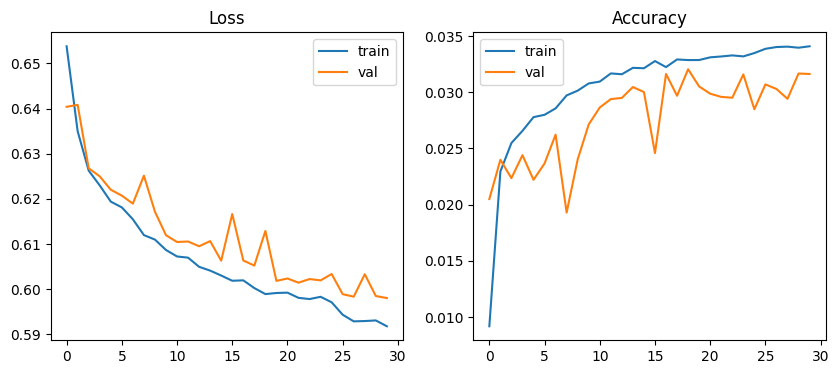

64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step
Mean IoU: 0.5460523


In [ ]:
# ========================================
# 📈 PERFORMANCE & IOU
# ========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

def iou_metric(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

preds = model.predict(val_ds)
preds_bin = (preds > 0.5).astype(np.float32)

ious = [iou_metric(Y_val[i], preds_bin[i]) for i in range(len(Y_val))]
print("Mean IoU:", np.mean(ious))

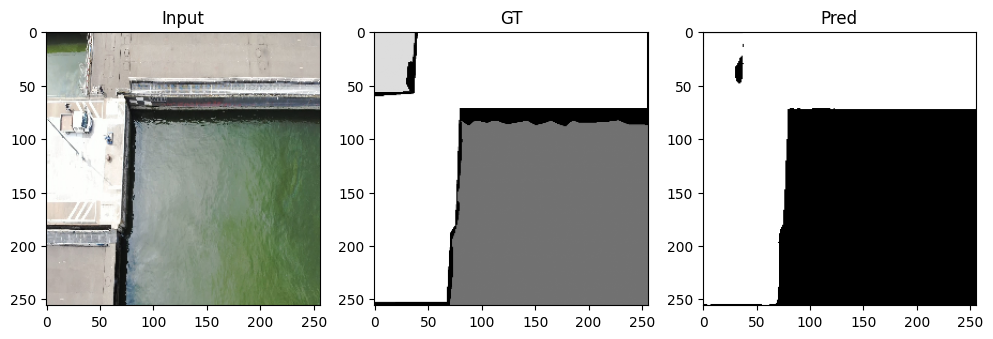

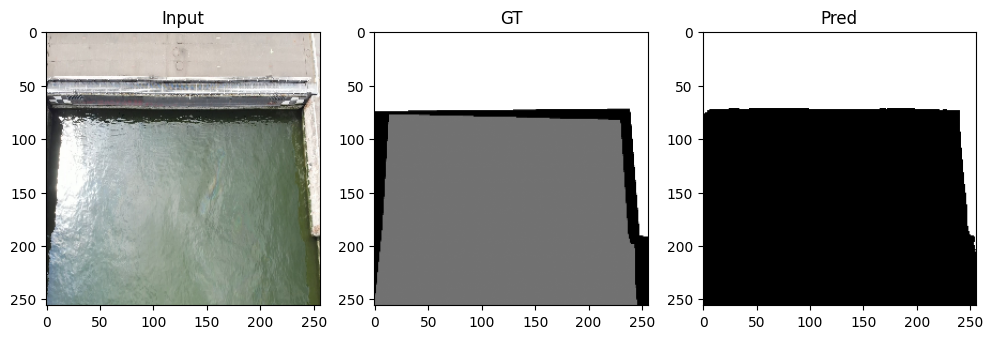

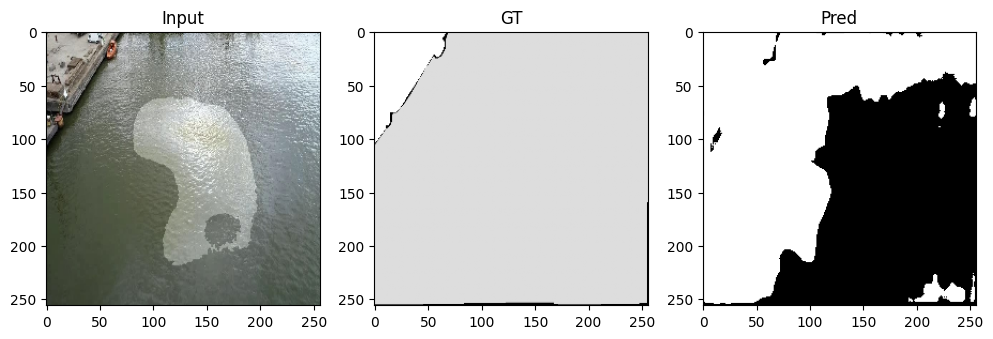

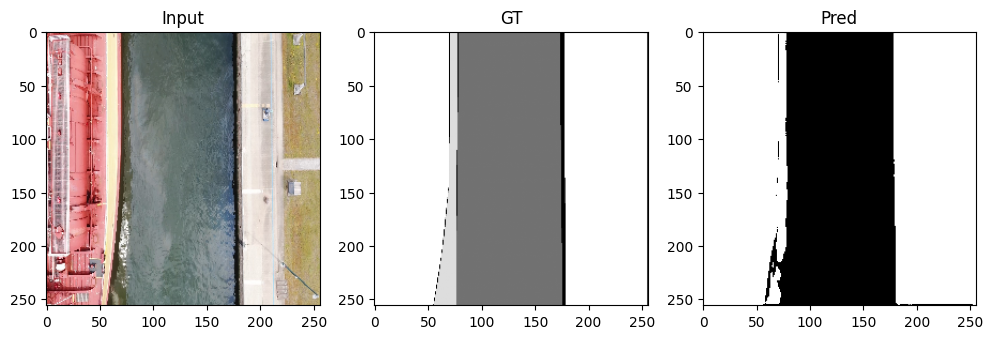

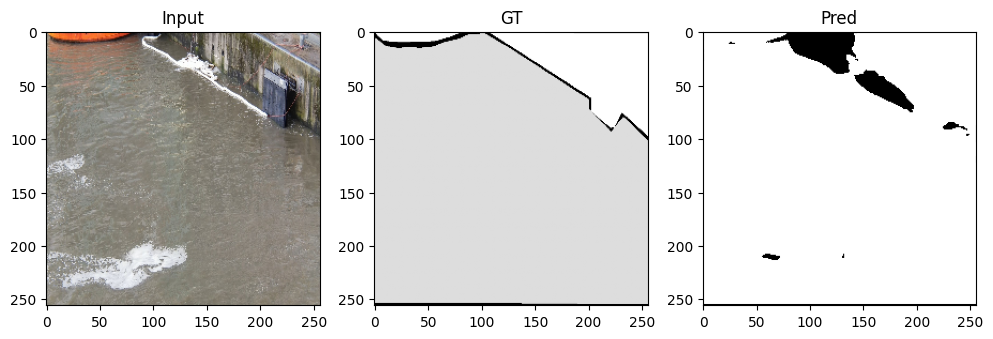

Saved examples to /content/outputs/preds/


In [ ]:
# ========================================
# 🎨 VISUALIZE & SAVE
# ========================================
os.makedirs("/content/outputs/preds", exist_ok=True)

for i in range(5):
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(X_val[i]); ax[0].set_title('Input')
    ax[1].imshow(np.squeeze(Y_val[i]), cmap='gray'); ax[1].set_title('GT')
    ax[2].imshow(np.squeeze(preds_bin[i]), cmap='gray'); ax[2].set_title('Pred')
    plt.savefig(f"/content/outputs/preds/result_{MODEL_NAME}_{i}.png")
    plt.show()

print("Saved examples to /content/outputs/preds/")

In [ ]:
# ========================================
# 9️⃣ BASELINE METRICS SNAPSHOT
# ========================================
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2 * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def bce_np(y_true, y_pred):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1).clip(1e-7, 1 - 1e-7)
    return -(y_true_f * np.log(y_pred_f) + (1 - y_true_f) * np.log(1 - y_pred_f)).mean()

baseline_preds = model.predict(X_val, batch_size=8, verbose=1)
baseline_preds_bin = (baseline_preds > 0.5).astype(np.float32)

dice_scores = [dice_coef_np(Y_val[i], baseline_preds_bin[i]) for i in range(len(Y_val))]
miou_scores = [iou_metric(Y_val[i], baseline_preds_bin[i]) for i in range(len(Y_val))]
bce_scores = [bce_np(Y_val[i], baseline_preds[i]) for i in range(len(Y_val))]

mean_dice = np.mean(dice_scores)
mean_iou = np.mean(miou_scores)
mean_bce = np.mean(bce_scores)
bce_dice_total = mean_bce + (1 - mean_dice)

print(f"Baseline Mean Dice: {mean_dice:.4f}")
print(f"Baseline Mean IoU:  {mean_iou:.4f}")
print(f"Baseline Mean BCE:  {mean_bce:.4f}")
print(f"BCE + Dice Loss:    {bce_dice_total:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 647ms/step
Baseline Mean Dice: 0.6788
Baseline Mean IoU:  0.5461
Baseline Mean BCE:  0.5981
BCE + Dice Loss:    0.9192
